# Creating a data set for the comparison with Huppenkothen+2017

Main classificatin experiments described in paper Orwat-Kapola+2021 were not directly comparable with the work of Daniela Huppenkothen, because the former classified whole light curves instead of 1024 s segments, and the cadence of the data was 1s/4s instead of 0.125 s.

Here we prepare a data set of 1024 s overlapping segments which are be further segmented into 16 s segments with cadence of 0.125s to make a direct comparison with Huppenkothen+2017.

In order to reduce the amount of generated data, the 1024 s segments created with a stride of 256 s and the 16 s segments are created with a stride of 16 s. The fact that light curve features are observed in only one phase shift position within those 16 s segments can affect the result. 

Huppenkothen+2017 used a total of 1884 previously classified samples, with 885 classified samples in the training set, 480 samples in the validation set and 519 samples in the test set, respectively.

In [185]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.insert(0, '../') # add parent folder path where /src folder is
from src import data_preprocessing

from IPython.display import clear_output
import os
import fnmatch
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import pandas as pd
# import matplotlib.pyplot as plt

data_dir = "../../data_GRS1915/"
raw_data_dir = "../../data_GRS1915/std1/" # directory path to where lightcurve files are located
raw_file_name_suffix = "_std1_lc.txt" # light curves were saved as txt files which are directly interpretable by numpy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# load light curves from text files

lcs=[] # light curves (time stamps, count rate, uncertainty)
lc_ids=[] # observation ids

for root, dirnames, filenames in os.walk(raw_data_dir): #Std1_PCU2
    for filename in fnmatch.filter(filenames, "*{}".format(raw_file_name_suffix)):
        lc = os.path.join(root, filename)
        lc_ids.append(filename.split("_")[0])
        f=np.loadtxt(lc)
        f=np.transpose(f)
        lcs.append(f)
        print("Loaded {} lightcurves".format(len(lcs)))
        clear_output(wait=True)
print("Finished")

Loaded 1776 lightcurves


In [4]:
# segmentation of light curves

seg_ids=[]
segments_list = []

for lc_index, lc in enumerate(lcs):
    segments = data_preprocessing.segmentation(time_series = lc, 
                                       segment_length_sec = 1024, 
                                       stride_sec = 256, 
                                       keep_time_stamps = True, 
                                       input_cadence_sec = 0.125)
    if len(segments) > 0:
        segments_list.append(segments)
        for seg_index, seg in enumerate(segments):
            seg_ids.append(lc_ids[lc_index]+"_{}".format(seg_index))
            
    clear_output(wait=True)
    print("Processed {}/{} light curves.".format(lc_index+1, len(lcs)))
print("Successfully segmented {} light curves.".format(len(segments_times)))

segments_list =  [item for sublist in segments_list for item in sublist] # vstack the list of lists of data segments

print("Prepared {} segments.".format(len(segments_list)))

Processed 1776/1776 light curves.
Successfully segmented 1442 light curves.
Prepared 11028 segments.


In [252]:
# load human-labelled classifications from Huppenkothen+2017

clean_belloni = open('{}/1915Belloniclass_updated.dat'.format(data_dir))
lines = clean_belloni.readlines()
states = lines[0].split()
belloni_clean = {}
for h,l in zip(states, lines[1:]):
    belloni_clean[h] = l.split()
    #state: obsID1, obsID2...
ob_state = {}
for state, obs in belloni_clean.items():
    if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
    for ob in obs:
        ob_state[ob] = state
        
ob_state["10258-01-10-00"] = "mu" # this one seems to be misclassified in Huppenkothen+2017
        
# inverse the ob_state dictionary, so that inv_ob_state contains {"state name" : [list of observation IDs], ...}

inv_ob_state = {}
for k, v in ob_state.items():
    inv_ob_state[v] = inv_ob_state.get(v, [])
    inv_ob_state[v].append(k)

30703-01-28-01 rho


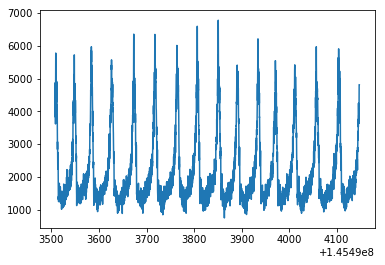

sum of GTI durations in seconds:  639.875



10408-01-14-01 delta


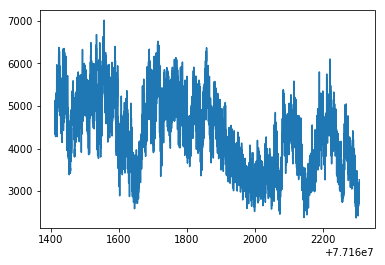

sum of GTI durations in seconds:  895.875



20402-01-43-02 beta


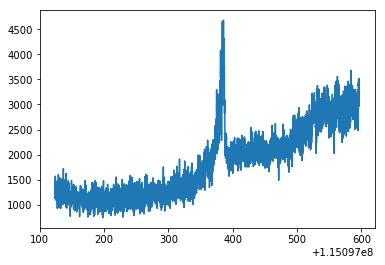

sum of GTI durations in seconds:  472.375
individual GTI durations in seconds:
6.875
465.5



10408-01-17-03 delta


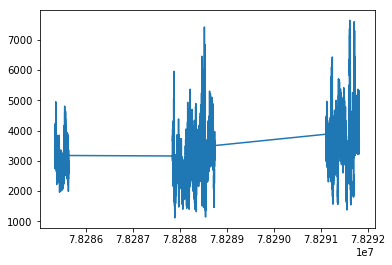

sum of GTI durations in seconds:  1888.25
individual GTI durations in seconds:
290.5
894.875
702.75



40703-01-41-01 chi


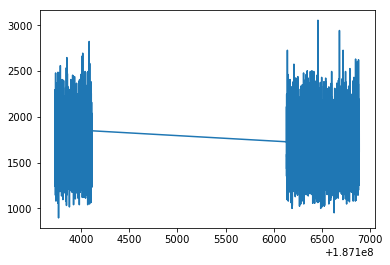

sum of GTI durations in seconds:  1137.875
individual GTI durations in seconds:
383.875
754.0



20402-01-43-01 mu


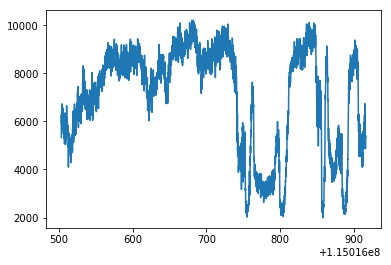

sum of GTI durations in seconds:  412.625



80127-01-01-00 eta


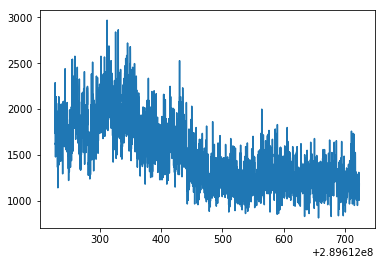

sum of GTI durations in seconds:  496.625



10408-01-16-04 theta


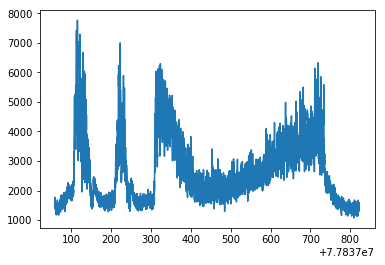

sum of GTI durations in seconds:  762.75



40703-01-33-01 delta


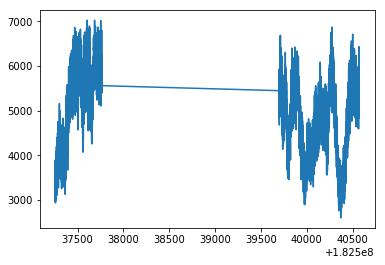

sum of GTI durations in seconds:  1386.375
individual GTI durations in seconds:
511.875
874.5



40703-01-20-02 chi


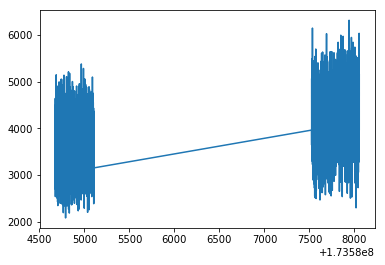

sum of GTI durations in seconds:  965.75
individual GTI durations in seconds:
435.375
530.375



40703-01-41-03 chi


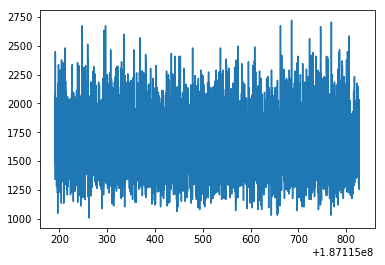

sum of GTI durations in seconds:  636.625



40703-01-14-00 kappa


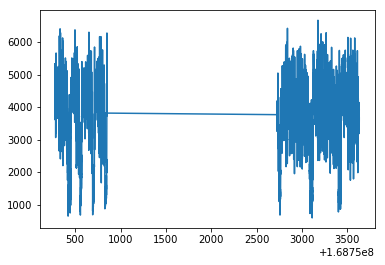

sum of GTI durations in seconds:  1482.75
individual GTI durations in seconds:
575.25
907.5



40703-01-14-02 kappa


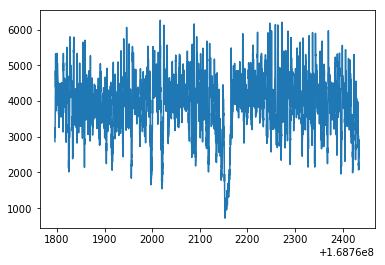

sum of GTI durations in seconds:  639.875



10408-01-14-03 delta


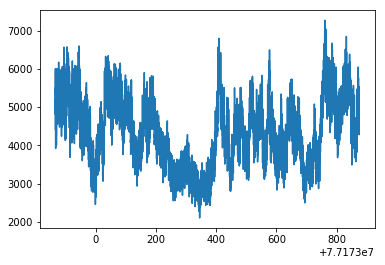

sum of GTI durations in seconds:  1010.25



40703-01-14-01 kappa


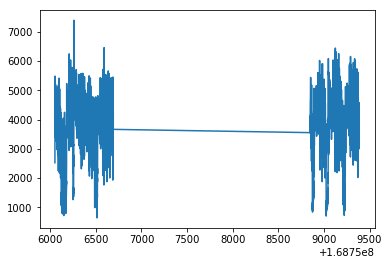

sum of GTI durations in seconds:  1175.75
individual GTI durations in seconds:
639.875
535.875



40703-01-42-01 chi


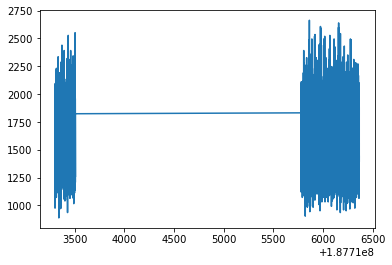

sum of GTI durations in seconds:  790.875
individual GTI durations in seconds:
205.875
585.0



20402-01-52-01 beta


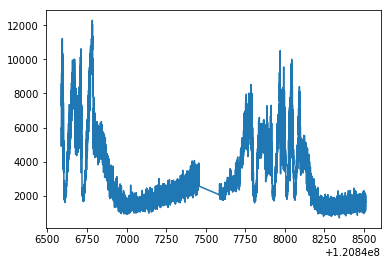

sum of GTI durations in seconds:  1794.5
individual GTI durations in seconds:
46.875
823.875
923.625



10408-01-14-05 delta


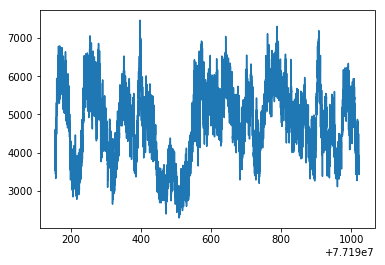

sum of GTI durations in seconds:  868.375



20402-01-30-02 alpha


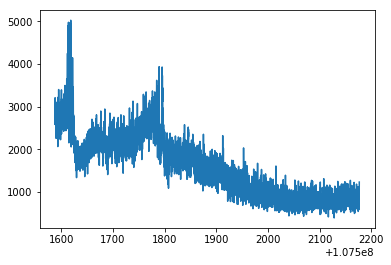

sum of GTI durations in seconds:  589.5



20402-01-36-01 lambda


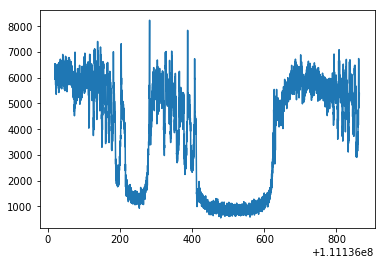

sum of GTI durations in seconds:  843.875



10408-01-18-01 delta


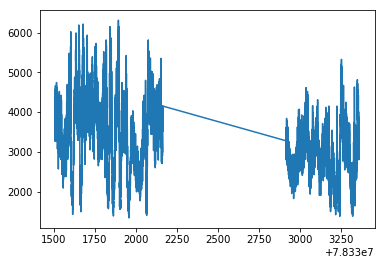

sum of GTI durations in seconds:  1104.875
individual GTI durations in seconds:
656.875
448.0



20402-01-34-00 rho


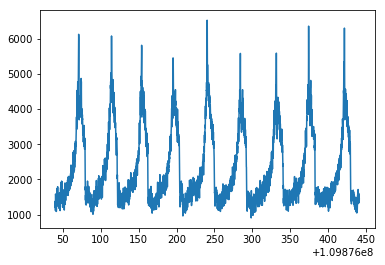

sum of GTI durations in seconds:  401.875



10408-01-09-00 phi
No data



40703-01-33-02 delta


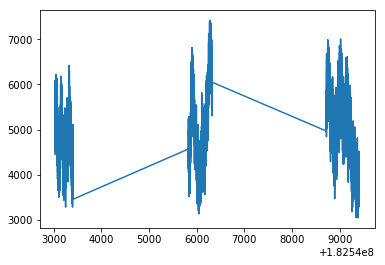

sum of GTI durations in seconds:  1575.75
individual GTI durations in seconds:
383.875
499.5
692.25



40703-01-42-03 chi


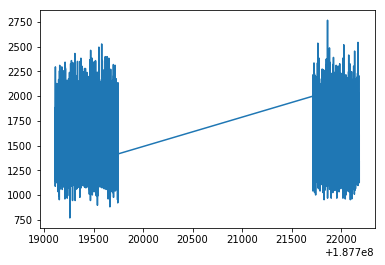

sum of GTI durations in seconds:  1108.75
individual GTI durations in seconds:
639.875
468.875



10408-01-14-07 delta


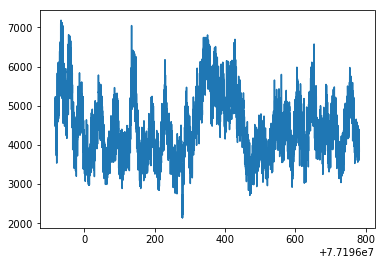

sum of GTI durations in seconds:  865.5



20402-01-24-01 alpha


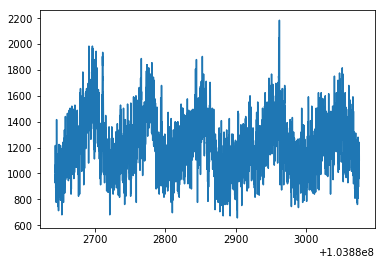

sum of GTI durations in seconds:  431.5



40703-01-20-03 chi


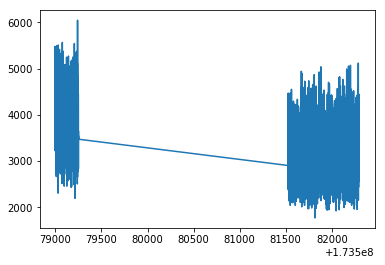

sum of GTI durations in seconds:  1030.5
individual GTI durations in seconds:
255.875
774.625



10408-01-15-03 theta


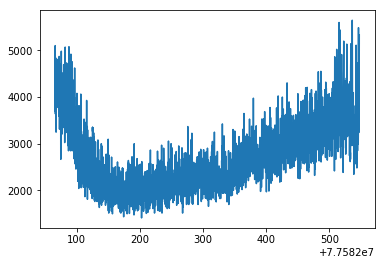

sum of GTI durations in seconds:  482.125



40703-01-34-02 delta


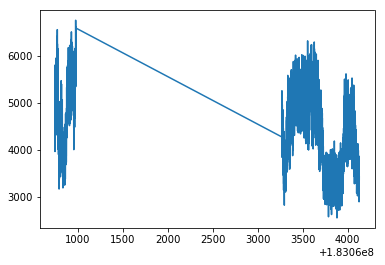

sum of GTI durations in seconds:  1097.5
individual GTI durations in seconds:
234.875
862.625



40703-01-41-02 chi


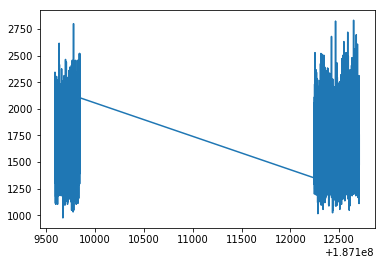

sum of GTI durations in seconds:  717.875
individual GTI durations in seconds:
255.875
462.0



10408-01-14-08 delta


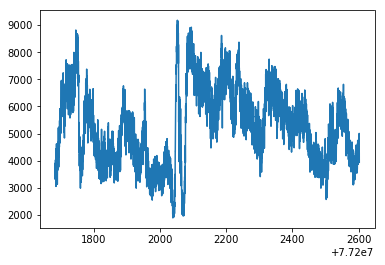

sum of GTI durations in seconds:  918.875



32


In [16]:
# make sure that the data labelled data does not allow for any more segments to be extracted

data_preprocessing.verify_not_segmented_light_curves(lcs, ob_state, seg_ids, lc_ids)

In [17]:
# check how many labelled light curves were segmented and count the number for each class
# count how many labelled segments there are for each class

labelled_with_segments = []
for k, v in ob_state.items():
    if k in [x.split("_")[0] for x in seg_ids]:
        labelled_with_segments.append(v)
class_names, class_obs_counts = np.unique(np.array(labelled_with_segments), return_counts=True)

labelled_segments = []
for x in [x.split("_")[0] for x in seg_ids]:
    if x in ob_state.keys():
        labelled_segments.append(ob_state[x])
class_names, class_seg_counts = np.unique(np.array(labelled_segments), return_counts=True)


for class_name, class_obs_count, class_seg_count  in zip(class_names,class_obs_counts,class_seg_counts):
    print("{}\t{}\t{}".format(class_name, class_obs_count, class_seg_count))
print("\nsum\t{}\t{}".format(np.sum(class_obs_counts), np.sum(class_seg_counts)))

alpha	6	66
beta	14	142
chi	70	888
delta	13	66
eta	2	46
gamma	12	163
kappa	9	117
lambda	3	43
mu	6	69
nu	3	47
omega	3	16
phi	9	107
rho	17	159
theta	17	212

sum	184	2141


# split data into training, validation and test sets
50/25/25 split ratio

Huppenkothen+2017 used a total of 1884 previously classified samples, with 885 classified samples in the training set, 480 samples in the validation set and 519 samples in the test set, respectively

In [257]:
# get rid of the within-observation segment indices and create a degenerate list of observation IDs
seg_ob_IDs_unique = np.unique([seg.split("_")[0] for seg in seg_ids])

# create list of observation classifications including those without a label
classes = np.array(["alpha", "beta", "gamma", "delta", "theta", "kappa", "lambda", "mu", "nu", "rho", "phi", "chi", "eta", "omega"])
labelled_obs_class = []
labelled_obs_id = []
for seg in seg_ob_IDs_unique:
    if seg in ob_state.keys():
        labelled_obs_class.append(ob_state[seg])
        labelled_obs_id.append(seg)
    else:
        labelled_obs_class.append("no_label")
        labelled_obs_id.append(seg)
        
print(np.unique(seg_class, return_counts=True))

(array(['alpha', 'beta', 'chi', 'delta', 'eta', 'gamma', 'kappa', 'lambda',
       'mu', 'no_label', 'nu', 'omega', 'phi', 'rho', 'theta'],
      dtype='<U8'), array([   6,   14,   70,   13,    2,   12,    9,    3,    6, 1258,    3,
          3,    9,   17,   17]))


In [276]:
# split observations between training and test sets

ob_ids_train, ob_ids_test, training_classes_ob, test_classes_ob = train_test_split(
    labelled_obs_id,
    labelled_obs_class,
    test_size=0.25, random_state=123456, stratify=labelled_obs_class)

# split observations between training and validation sets

ob_ids_train, ob_ids_valid, training_classes_ob, validation_classes_ob = train_test_split(
    ob_ids_train,
    training_classes_ob,
    test_size=0.33, random_state=123456, stratify=training_classes_ob)

# no_label segments are not needed in the test set, so they will be moved to the training set.

to_be_moved = []
for ob_index, ob_class in enumerate(test_classes_ob):
    if ob_class == "no_label":
        to_be_moved.append(True)
    else:
        to_be_moved.append(False)    
to_be_moved = np.array(to_be_moved)

ob_ids_train = np.concatenate((ob_ids_train, np.array(ob_ids_test)[to_be_moved]))
training_classes_ob = np.concatenate((training_classes_ob, np.array(test_classes_ob)[to_be_moved]))

ob_ids_test = np.array(ob_ids_test)[~to_be_moved]
test_classes_ob = np.array(test_classes_ob)[~to_be_moved]

In [277]:
# find the number of segments of each class in training, validation and test sets

seg_ob_IDs = [seg.split("_")[0] for seg in seg_ids]

training_classes_seg = []
for seg_ob_ID in seg_ob_IDs:
    if seg_ob_ID in ob_ids_train:
        if seg_ob_ID in ob_state.keys():
            training_classes_seg.append(ob_state[seg_ob_ID])
        else:
            training_classes_seg.append("no_label")
        
validation_classes_seg = []
for seg_ob_ID in seg_ob_IDs:
    if seg_ob_ID in ob_ids_valid:
        if seg_ob_ID in ob_state.keys():
            validation_classes_seg.append(ob_state[seg_ob_ID])
        else:
            validation_classes_seg.append("no_label")
            
test_classes_seg = []
for seg_ob_ID in seg_ob_IDs:
    if seg_ob_ID in ob_ids_test:
        if seg_ob_ID in ob_state.keys():
            test_classes_seg.append(ob_state[seg_ob_ID])
        else:
            test_classes_seg.append("no_label")


train_seg_class_names, train_seg_class_counts = np.unique(training_classes_seg, return_counts=True)
validation_seg_class_names, validation_seg_class_counts = np.unique(validation_classes_seg, return_counts=True)
test_seg_class_names, test_seg_class_counts = np.unique(test_classes_seg, return_counts=True)

training_pd_series = pd.DataFrame(index = train_seg_class_names, data=train_seg_class_counts, columns=["train set"])
validation_pd_series = pd.DataFrame(index = validation_seg_class_names, data=validation_seg_class_counts, columns=["valid set"])
test_pd_series = pd.DataFrame(index = test_seg_class_names, data=test_seg_class_counts, columns=["test set"])

seg_counts_df = training_pd_series.join(validation_pd_series).join(test_pd_series).fillna(0).astype(int)
seg_counts_df_sums = pd.DataFrame({'sum labelled': seg_counts_df.sum()-seg_counts_df.loc['no_label'],
                                           'sum total': seg_counts_df.sum()})

# seg_counts_df.loc['sum labelled'] = seg_counts_df.sum()
# seg_counts_df.loc['sum labelled'] -= seg_counts_df.loc['no_label']
seg_counts_df_perc_labelled = pd.DataFrame({'% labelled': (seg_counts_df_sums['sum labelled']/seg_counts_df_sums['sum labelled'].sum()*100)})
print(seg_counts_df)
print()
print(seg_counts_df_sums.T)
print()
print(seg_counts_df_perc_labelled.T)

          train set  valid set  test set
alpha            26          6        34
beta             84         25        33
chi             367        273       248
delta            11         12        43
eta               6         40         0
gamma           108         38        17
kappa            76          5        36
lambda           18         16         0
mu               38          7        33
no_label       6573       2314         0
nu               18         20         9
omega             2          3        11
phi              62         36         9
rho              98         29        32
theta            69         82        61

              train set  valid set  test set
sum labelled        983        592       566
sum total          7556       2906       566

            train set  valid set   test set
% labelled  45.913125  27.650631  26.436245


In [281]:
# create separate segment list for each subset

segments_train = []
segments_valid = []
segments_test = []

for seg_id, segment in zip(seg_ids,segments_list):
    seg_ob_id = seg_id.split("_")[0]
    if seg_ob_id in ob_ids_train:
        if seg_ob_id in ob_state.keys():
            segments_train.append((seg_id, ob_state[seg_ob_id], segment))
        else:
            segments_train.append((seg_id, "no_label", segment))
    elif seg_ob_id in ob_ids_valid:
        if seg_ob_id in ob_state.keys():
            segments_valid.append((seg_id, ob_state[seg_ob_id], segment))
        else:
            segments_valid.append((seg_id, "no_label", segment))
    elif seg_ob_id in ob_ids_test:
        if seg_ob_id in ob_state.keys():
            segments_test.append((seg_id, ob_state[seg_ob_id], segment))
        else:
            segments_test.append((seg_id, "no_label", segment))

print(len(segments_train),len(segments_valid),len(segments_test))

7556 2906 566


In [286]:
# save segments for later use

# with open('{}/segments_1024s_256stride_0125cad_train.pkl'.format(data_dir), 'wb') as f:
#     pickle.dump(segments_train, f)

# with open('{}/segments_1024s_256stride_0125cad_valid.pkl'.format(data_dir), 'wb') as f:
#     pickle.dump(segments_valid, f)

# with open('{}/segments_1024s_256stride_0125cad_test.pkl'.format(data_dir), 'wb') as f:
#     pickle.dump(segments_test, f)

# segmentation of 1024 second segments

In [18]:
# segmentation of 1024 second segments

segments_counts=[]
segments_times = []
segments_errors=[]
seg128_ids=[]

for lc_index, lc in enumerate(segments_list):
    segments = data_preprocessing.segmentation(time_series = lc, 
                                       segment_length_sec = 128*0.125, 
                                       stride_sec = 128*0.125, 
                                       keep_time_stamps = True, 
                                       input_cadence_sec = 0.125)
    if len(segments) > 0:
        segments_times.append(segments[:,0,:])
        segments_counts.append(segments[:,1,:])
        segments_errors.append(segments[:,2,:])
        for seg_index, seg in enumerate(segments):
            seg128_ids.append(seg_ids[lc_index]+"_{}".format(seg_index))
            
    if lc_index%100 == 0 or lc_index+1 == len(segments_list) or lc_index == 0:
        clear_output(wait=True)
        print("Processed {}/{} light curves.".format(lc_index+1, len(segments_list)))
print("Successfully segmented {} light curves.".format(len(segments_times)))

segments_counts=np.vstack(segments_counts)
segments_errors=np.vstack(segments_errors)
segments_counts = np.expand_dims(segments_counts, axis=-1)
segments_errors = np.expand_dims(segments_errors, axis=-1)

print("Prepared {} segments.".format(len(segments_counts)))

Processed 11028/11028 light curves.
Successfully segmented 11028 light curves.
Prepared 705792 segments.


In [19]:
11028*64

705792

In [45]:
for start in range(0, int(1024-128), 128):
    print(start)

0
128
256
384
512
640
768


In [51]:
for start in np.linspace(0, int(1024-128), int(1024/128), dtype=int):
    print(start)

0
128
256
384
512
640
768
896
